In [62]:
import numpy as np
from src.cyc_gbm import CycGBM, CycGLM
from src.cyc_gbm.utils import tune_kappa, train_test_split
from src.cyc_gbm.distributions import initiate_distribution
from matplotlib import pyplot as plt
import pandas as pd

In [63]:
# Simulation parameters
n = 100000
p = 9
dist = "normal"
simulation_seed = 10
cv_seed = 11


def parameter_function(X):
    z0 = (
        -1
        + 0.5 * X[:, 1]
        - 0.25 * X[:, 2] ** 2
        + 0.5 * np.abs(X[:, 3]) * np.sin(2 * X[:, 3]) * 0.25 * X[:, 4] * X[:, 5]
        + 0.125 * X[:, 5] ** 2 * X[:, 6]
    )
    z1 = 2 + 0.3 * X[:, 2] + 0.02 * np.abs(X[:, 1])
    return np.stack([z0, z1])


# GBM hyperparameters
kappa_max = 100
eps_gbm = 0.1
max_depth = 3
min_samples_leaf = 5
n_splits = 10

# GLM hyperparameters
max_iter = 1000
eps_glm = 1e-5
tol = 0.001

## Simulate data

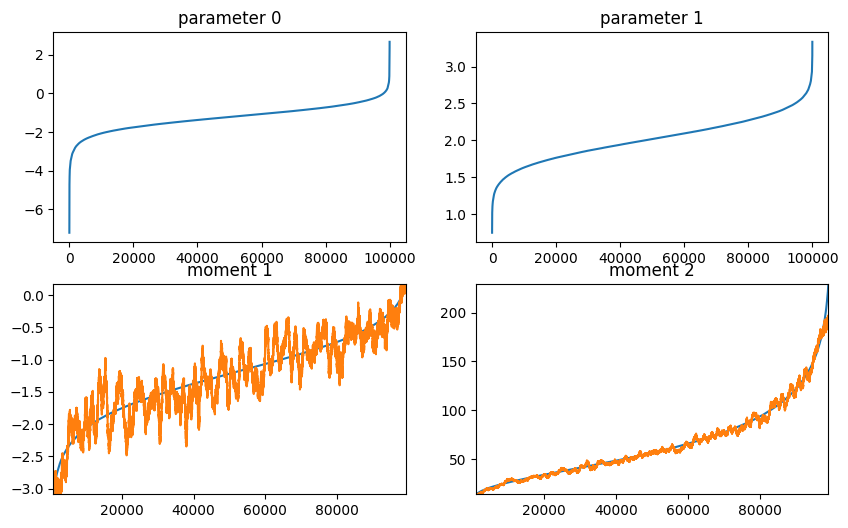

In [64]:
def moving_average(y, window_size=100):
    return np.convolve(y, np.ones(window_size), "full") / window_size


def moving_variance(y, z, w, window_size):
    r = y - distribution.moment(z=z, w=w, k=1)
    return np.convolve(r**2, np.ones(window_size), "full") / window_size


def moving_moment(y, window_size, z, w, k):
    if k == 1:
        return moving_average(y, window_size)
    elif k == 2:
        return moving_variance(y, z=z, w=w, window_size=window_size)


rng = np.random.default_rng(seed=simulation_seed)
X = np.concatenate([np.ones((1, n)), rng.normal(0, 1, (p - 1, n))]).T
# w = rng.choice([1, 3,5,10], p=[0.4,0.3,0.2,0.1], size=n)
w = np.ones(n)

distribution = initiate_distribution(dist=dist)
z = parameter_function(X)
y = distribution.simulate(z=z, w=w, rng=rng)
X_train, X_test, y_train, y_test, z_train, z_test, w_train, w_test = train_test_split(
    X=X, y=y, z=z, w=w, test_size=0.2, rng=rng
)
z_hat = {
    data_set: {
        model: None for model in ["intercept", "glm", "uni-gbm", "cyc-gbm", "true"]
    }
    for data_set in ["train", "test"]
}

z_hat["train"]["true"] = z_train
z_hat["test"]["true"] = z_test

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()

# parameters
for j in range(distribution.d):
    axs[j].set_title(f"parameter {j}")
    sort_order = np.argsort(z[j])
    axs[j].plot(z[j][sort_order])

# moments
window_size = n // 100
for k in [1, 2]:
    axs[k + 1].set_title(f"moment {k}")
    moment = distribution.moment(z=z, w=w, k=k)
    sort_order = np.argsort(moment)

    moment_empirical = moving_moment(
        y[sort_order], window_size=window_size, z=z[:, sort_order], w=w[sort_order], k=k
    )
    axs[k + 1].plot(moment[sort_order], label="true")
    axs[k + 1].plot(moment_empirical, label="empirical")
    axs[k + 1].set_xlim([window_size, n - window_size])
    axs[k + 1].set_ylim(
        [
            min(moment[sort_order][window_size : n - window_size]),
            max(moment[sort_order][window_size : n - window_size]),
        ]
    )

## Intercept

In [65]:
z0 = distribution.mle(y=y_train, w=w_train)[:, None]
z_hat["train"]["intercept"] = np.tile(z0, (1, len(y_train)))
z_hat["test"]["intercept"] = np.tile(z0, (2, len(y_test)))

## Cyclical GLM

In [66]:
glm = CycGLM(dist="normal", eps=eps_glm, max_iter=max_iter, tol=tol)

glm.fit(X=X_train, y=y_train, w=w_train)

z_hat["train"]["glm"] = glm.predict(X_train)
z_hat["test"]["glm"] = glm.predict(X_test)

/Users/Henning/PycharmProjects/c-gbm/src/cyc_gbm/distributions.py:289: RuntimeWarning: overflow encountered in exp
  return -np.exp(-2 * z[1]) * (y - z[0]) / (w**2)
/Users/Henning/PycharmProjects/c-gbm/src/cyc_gbm/cyc_glm.py:58: RuntimeWarning: invalid value encountered in matmul
  beta_hat[i, j] = beta_hat[i - 1, j] - self.eps[j] * g @ X
/Users/Henning/PycharmProjects/c-gbm/src/cyc_gbm/distributions.py:291: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-2 * z[1]) * (y - z[0]) ** 2 / (w**2)


### Univariate GBM

In [67]:
# Tune kappa
kappa_uni = tune_kappa(
    X=X_train,
    y=y_train,
    w=w_train,
    n_splits=n_splits,
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    kappa_max=[kappa_max, 0],
    dist=dist,
    random_state=cv_seed,
    verbose=1,
)["kappa"]

gbm_uni = CycGBM(
    kappa=kappa_uni,
    dist="normal",
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_uni.fit(X=X_train, y=y_train, w=w_train)

z_hat["train"]["uni-gbm"] = gbm_uni.predict(X_train)
z_hat["test"]["uni-gbm"] = gbm_uni.predict(X_test)

2023-05-11 18:39:20,187 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 10-fold cross-validation
2023-05-11 18:39:20,192 - src.cyc_gbm.utils - INFO - Fold 1/10
2023-05-11 18:39:28,492 - src.cyc_gbm.utils - INFO - Fold 2/10
2023-05-11 18:39:37,009 - src.cyc_gbm.utils - INFO - Fold 3/10
2023-05-11 18:39:45,006 - src.cyc_gbm.utils - INFO - Fold 4/10
2023-05-11 18:39:48,900 - src.cyc_gbm.utils - INFO - Fold 5/10
2023-05-11 18:39:58,903 - src.cyc_gbm.utils - INFO - Fold 6/10
2023-05-11 18:40:05,280 - src.cyc_gbm.utils - INFO - Fold 7/10
2023-05-11 18:40:16,906 - src.cyc_gbm.utils - INFO - Fold 8/10
2023-05-11 18:40:27,118 - src.cyc_gbm.utils - INFO - Fold 9/10
2023-05-11 18:40:31,655 - src.cyc_gbm.utils - INFO - Fold 10/10
2023-05-11 18:40:37,831 - src.cyc_gbm.utils - INFO - Finished tuning of kappa with 10-fold cross-validation


#### Cyclical GBM

In [68]:
kappa_cyc = tune_kappa(
    X=X_train,
    y=y_train,
    w=w_train,
    n_splits=n_splits,
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    kappa_max=kappa_max,
    dist=dist,
    random_state=cv_seed,
    verbose=1,
)["kappa"]

gbm_cyc = CycGBM(
    kappa=kappa_cyc,
    dist="normal",
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_cyc.fit(X=X_train, y=y_train, w=w_train)

z_hat["train"]["cyc-gbm"] = gbm_cyc.predict(X_train)
z_hat["test"]["cyc-gbm"] = gbm_cyc.predict(X_test)

2023-05-11 18:40:50,017 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 10-fold cross-validation
2023-05-11 18:40:50,018 - src.cyc_gbm.utils - INFO - Fold 1/10
2023-05-11 18:41:43,297 - src.cyc_gbm.utils - INFO - Fold 2/10
2023-05-11 18:42:31,340 - src.cyc_gbm.utils - INFO - Fold 3/10
2023-05-11 18:45:06,581 - src.cyc_gbm.utils - INFO - Fold 4/10
2023-05-11 18:45:58,061 - src.cyc_gbm.utils - INFO - Fold 5/10
2023-05-11 18:47:15,960 - src.cyc_gbm.utils - INFO - Fold 6/10
2023-05-11 18:48:04,933 - src.cyc_gbm.utils - INFO - Fold 7/10
2023-05-11 18:49:09,803 - src.cyc_gbm.utils - INFO - Fold 8/10
2023-05-11 18:49:59,947 - src.cyc_gbm.utils - INFO - Fold 9/10
2023-05-11 18:50:52,316 - src.cyc_gbm.utils - INFO - Fold 10/10
2023-05-11 18:51:51,171 - src.cyc_gbm.utils - INFO - Finished tuning of kappa with 10-fold cross-validation


## Results

boosting steps:
         kappa_0  kappa_1
uni-gbm       18        0
cyc-gbm       32       37

losses:
           train   test
intercept  2.612  2.609
glm          NaN    NaN
uni-gbm    2.608  2.608
cyc-gbm    2.514  2.518
true       2.516  2.517


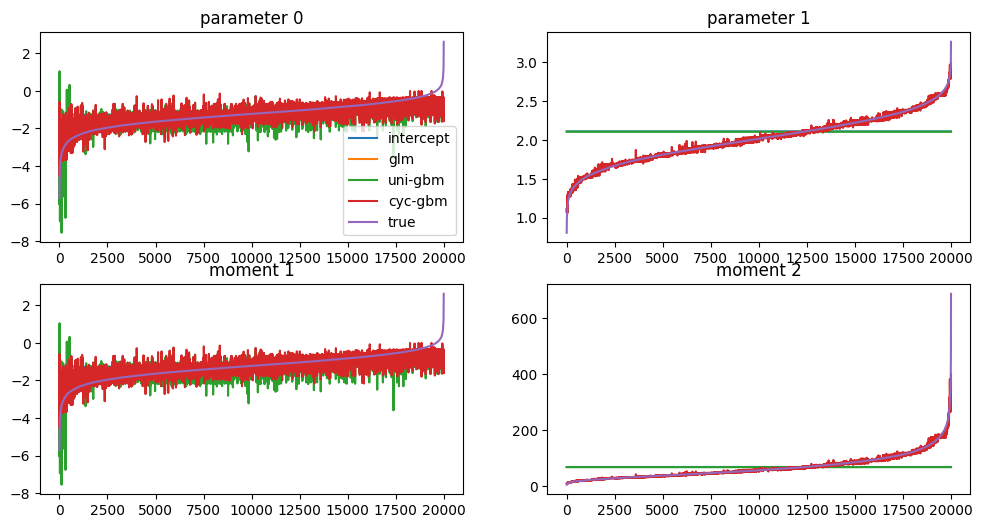

In [69]:
# Tuning results
kappas = pd.DataFrame(
    columns=[f"kappa_{j}" for j in range(0, distribution.d)],
    index=["uni-gbm", "cyc-gbm"],
    dtype=int,
)
kappas.loc["uni-gbm", :] = kappa_uni
kappas.loc["cyc-gbm", :] = kappa_cyc

print("boosting steps:")
print(kappas.astype(int))

# Losses
losses = pd.DataFrame(
    columns=["train", "test"],
    index=z_hat["train"].keys(),
    dtype=float,
)
for data_set, y_set, w_set in [("train", y_train, w_train), ("test", y_test, w_test)]:
    for model in z_hat[data_set].keys():
        losses.loc[model, data_set] = distribution.loss(
            y=y_set, z=z_hat[data_set][model], w=w_set
        ).mean()
print("\nlosses:")
print(losses.round(3))

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, distribution.d)

# Parameter estimates
for j in range(distribution.d):
    ax = fig.add_subplot(gs[0, j])
    ax.set_title(f"parameter {j}")
    sort_order = np.argsort(z_hat["test"]["true"][j])
    for model in z_hat["train"].keys():
        ax.plot(z_hat["test"][model][j][sort_order], label=model)
    if j == 0:
        ax.legend()

# Moment estimates
for k in [1, 2]:
    ax = fig.add_subplot(gs[1, k - 1])
    ax.set_title(f"moment {k}")
    sort_order = np.argsort(distribution.moment(z=z_hat["test"]["true"], w=w_test, k=k))
    for model in z_hat["train"].keys():
        ax.plot(
            distribution.moment(z=z_hat["test"][model], w=w_test, k=k)[sort_order],
            label=model,
        )